In [1]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from IPython.display import Image, display
import os

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as prepro_res50
from tensorflow.keras.applications.vgg19 import preprocess_input as prepro_vgg19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, MaxPool2D, MaxPooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_data = '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir'
print(os.listdir(path_data))

['500_tenge', '1000_tenge', '2000_tenge', '5000_tenge', '10000_tenge', '20000_tenge']


In [4]:
from os.path import join

img_folders = [join(path_data, folder) for folder in os.listdir(path_data)]
list(img_folders)

['/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/500_tenge',
 '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/1000_tenge',
 '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/2000_tenge',
 '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/5000_tenge',
 '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/10000_tenge',
 '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/20000_tenge']

In [11]:
data_dir = '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir'

data = load_files(data_dir, random_state=28, shuffle=True)
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

# remove eventual .pyc or .py files


print(f'Data files - {X}')
print(f'Target labels - {y}')
print(f'Name labels - {labels}')
print(f'Number of training files : {X.shape[0]}')

Data files - ['/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/10000_tenge/10000_77_0.5_0.55957_0.886719_0.492188.jpg'
 '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/1000_tenge/1000_185_0.453613_0.571777_0.758789_0.813477.jpg'
 '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/10000_tenge/10000_136_0.385742_0.527832_0.451172_0.59668.jpg'
 ...
 '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/10000_tenge/10000_36 (1)_0.472168_0.520996_0.327148_0.645508.jpg'
 '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/10000_tenge/10000_178_0.544922_0.452637_0.910156_0.411133.jpg'
 '/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir/500_tenge/500_105_0.509277_0.541992_0.973633_0.613281.jpg']
Target labels - [0 1 0 ... 0 0 5]
Name labels - ['10000_tenge' '1000_tenge' '20000_tenge' '2000_tenge' '5000_tenge'
 '500_tenge']
Number of training files : 1259


In [12]:
image_size = 224     # standard value for Transfer learning usecase (MobileNet, ResNet50, VGG16, VGG19)

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]   # load image
    img_array = np.array([img_to_array(img) for img in imgs])   # image to array
    return(img_array)

X = np.array(read_and_prep_images(X))
print(X.shape)  # = (num_images, height_size, width_size, depth=RGB)

(1259, 224, 224, 3)


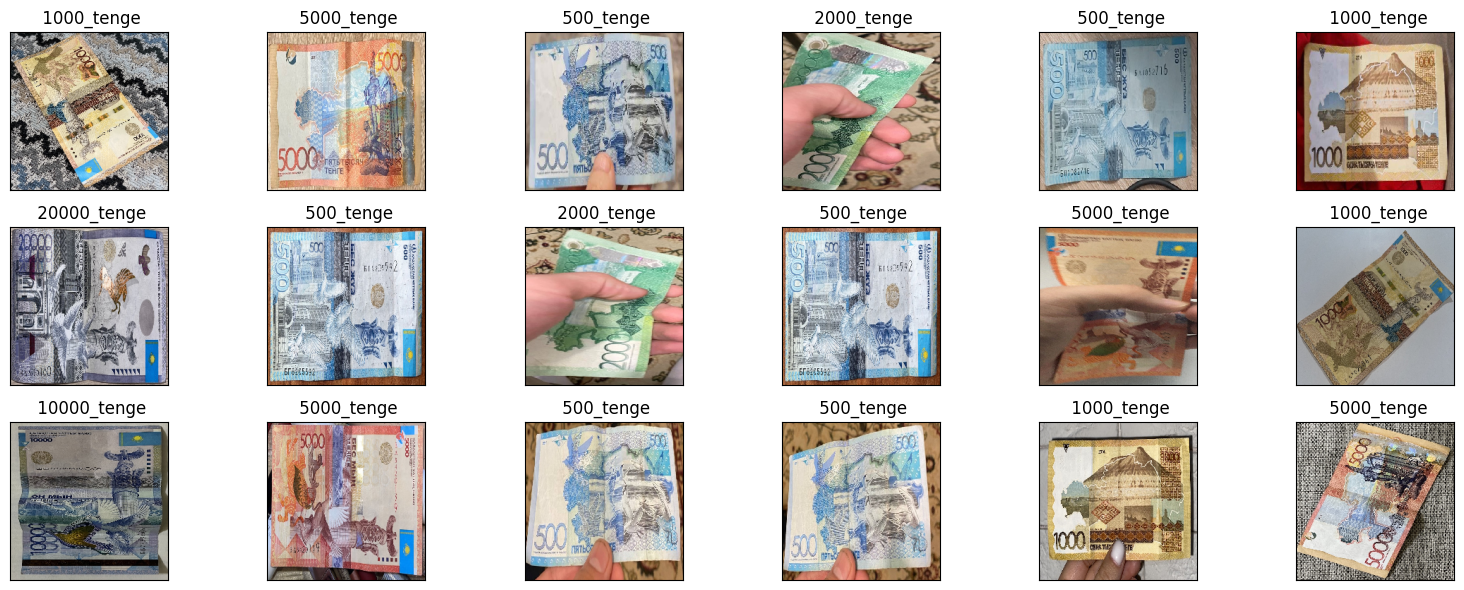

In [13]:
N = 18  # flowers to display
fig, axes = plt.subplots(3, 6, figsize=(16,6))
for ax, j in zip(axes.flat, np.random.randint(0, len(X), N)):
    ax.imshow(X[j].astype(np.uint8))
    ax.set(title=f' {labels[y[j]]}', xticks=[], yticks=[])
fig.tight_layout()

In [14]:
num_classes = len(np.unique(y))
print(f'Number of classes: {num_classes} --> {labels}')

Number of classes: 6 --> ['10000_tenge' '1000_tenge' '20000_tenge' '2000_tenge' '5000_tenge'
 '500_tenge']


In [15]:
y = to_categorical(y, num_classes)
print(y.shape)

(1259, 6)


In [16]:
#train, validation and test from the train dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True,
                                                test_size=0.25, random_state=28)

Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5,
                                            shuffle=True, random_state=28)
print(f'Train dataset: {Xtrain.shape[0]}')
print(f'Validation dataset: {Xval.shape[0]}')
print(f'Test dataset: {Xtest.shape[0]}')

Train dataset: 944
Validation dataset: 157
Test dataset: 158


In [17]:
# release memory
del X
# release memory
del y

In [18]:
# Load the VGG19 model without the final layers (include_top=False)
img_shape = (image_size, image_size, 3)

print('Loading MobileNetV2 ...')
base_model = MobileNetV2(input_shape=img_shape,
                   include_top=False,
                   weights='imagenet')
print('MobileNetV2 loaded')

base_model.trainable = False

#base_model.summary()

Loading MobileNetV2 ...
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2 loaded


In [19]:
model = Sequential([base_model,
                    GlobalAveragePooling2D(),
                    Dense(num_classes, activation='softmax')
                   ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [21]:
# callbacks
from tensorflow.keras.optimizers.legacy import RMSprop
weight_path = '{}_best_weights.hdf5'.format('banknote')
checkpointer = ModelCheckpoint(weight_path,
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='auto',
                               save_weights_only=True)

# set a learning rate annealer



from tensorflow.keras.optimizers import SGD

# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.7,
                                            min_lr=0.00001)

# early stop if not improvement of accuracy after 5 epochs
early = EarlyStopping(patience=6,
                      verbose=1)

callbacks = [checkpointer, learning_rate_reduction] #, early]

# Optimizer
opt = SGD(lr=0.001, momentum=0.9)

# Compilation
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [22]:
image_size = 224
batch_size = 32
path ='/content/drive/MyDrive/Kazakhstan_Banknotes_Dataset (1)/out_dir'


#train_gen = train_aug.flow(Xtrain, ytrain, batch_size=batch_size)
# The validation data must not have data augmentation
#valid_gen = valid_no_aug.flow(Xval, yval, batch_size=batch_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,           # rescale pixel values [0,255] to [0,1]
        horizontal_flip=True,     # random horizontal flip
        width_shift_range=0.2,    # random shift images horizontally (fraction of total width)
        height_shift_range=0.2,   # random shift images vertically (fraction of total height)
        zoom_range=0.2)           # random zoom image
        #rotation_range=20,       # random rotation
        #shear_range=0.2)         # shear transfo
        #validation_split=0.2)    # splitting train / test datasets

test_datagen = ImageDataGenerator(
        rescale=1./255)
        #validation_split=0.2)

train_gen = train_datagen.flow(
        Xtrain, ytrain,
        batch_size=batch_size,
        shuffle=False)              # already applied

valid_gen = test_datagen.flow(
        Xval, yval,
        batch_size=batch_size,
        shuffle=False)

In [23]:
batch_size = 32
epochs_0 = 20
steps_per_epoch = len(train_gen.x) // train_gen.batch_size
validation_steps = len(valid_gen.x) // valid_gen.batch_size

history = model.fit(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=epochs_0 ,
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 1.1855 - accuracy: 0.5757
Epoch 1: val_accuracy improved from -inf to 0.71875, saving model to banknote_best_weights.hdf5
29/29 [==============================] - 18s 423ms/step - loss: 1.1855 - accuracy: 0.5757 - val_loss: 0.7261 - val_accuracy: 0.7188 - lr: 0.0100
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8728
Epoch 2: val_accuracy improved from 0.71875 to 0.90625, saving model to banknote_best_weights.hdf5
29/29 [==============================] - 12s 401ms/step - loss: 0.3956 - accuracy: 0.8728 - val_loss: 0.3718 - val_accuracy: 0.9062 - lr: 0.0100
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9232
Epoch 3: val_accuracy did not improve from 0.90625
29/29 [==============================] - 10s 350ms/step - loss: 0.2374 - accuracy: 0.9232 - val_loss: 0.3943 - val_accuracy: 0.8359 - lr: 0.0100
Epoch 4/20
29/29 [===================

In [24]:
def plot_history(history, loss_max=5):
    """
    Check loss and accuracy evolution.
    """

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy',
            ylim=([min(plt.ylim()),1]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

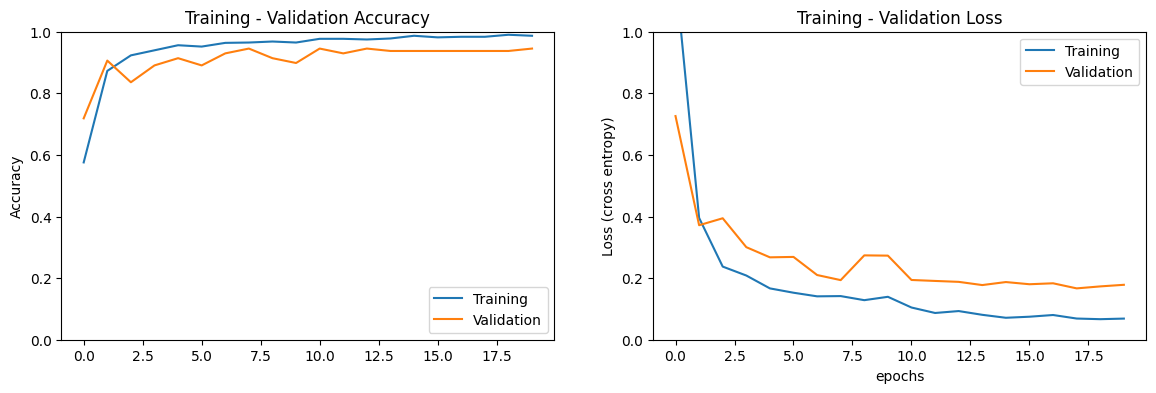

In [25]:
plot_history(history, loss_max=1)


In [26]:
# Generator for test dataset
datagen = ImageDataGenerator(
        rescale=1./255)

eval_datagen = datagen.flow(
        Xtest, ytest,
        batch_size=batch_size,
        shuffle=False)      # since shuffle was already during splitting into train, valid, test

# Evaluation on the test dataset
loss, acc = model.evaluate_generator(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

<ipython-input-26-f2021a0b2f6f>:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(eval_datagen, verbose=0)


Test loss: 0.19
Test accuracy: 94.30%
